# Sensitivity of Fold-Change to $F$

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [2]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.bayes
import mut.viz
import tqdm
pboc = mut.viz.color_selector('pboc')

constants = mut.thermo.load_constants()
mut.viz.plotting_style()

In my analysis, I have found that at the extremes of fold-change the $\Delta F$ is poorly resolved and has aninteresting trend towards $\Delta F = 0$. I think this has something to do with the fact that when you approach the asymptotes of fold-change, the magnitude of the empirical $F$ gets very large. As a reminder, the empirical $F$ can be calculated from the fold-change data as

$$
F_\text{empirical} = \log \left( {1 \over \text{fold-change}} -1\right)
$$

# Generating a fake data set
We can generate a dataset in which fold-change measurements are normally distributed about a value prescribed by the theory. 

In [502]:
sigma = 0.05
n_reps = 8 
true_bohr = np.linspace(-10, 20, 100)
dataset_fc = []
offset = 8 
fc_mu = (1 + np.exp(-true_bohr))**-1
fc_mut = (1 + np.exp(-true_bohr+offset))**-1
for i, b in enumerate(true_bohr):
    mu = fc_mut[i]
    dataset = np.random.normal(mu, sigma, n_reps)
    df = pd.DataFrame(dataset.T, columns=['fold_change'])
    df['replicate'] = np.arange(n_reps)
    df['true_bohr'] = b
    dataset_fc.append(df)
dataset = pd.concat(dataset_fc)

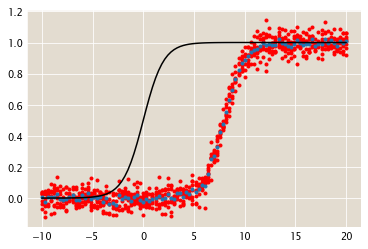

In [503]:

plt.plot(dataset['true_bohr'], dataset['fold_change'], 'r.')
plt.plot(true_bohr, dataset.groupby(['true_bohr'])['fold_change'].mean(),'.')
plt.plot(true_bohr, fc_mu, 'k-')


In [504]:
# Load the stan model
model = mut.bayes.StanModel('../stan/empirical_F.stan')# , force_compile=True)
stan_dfs = []
for g, d in dataset.groupby('true_bohr'):
    data_dict = {'N':len(d), 'ref_bohr':g, 'foldchange':d['fold_change']}
    fit, samples = model.sample(data_dict, iter=2000, control=dict(adapt_delta=0.9))
    
    # Correct past extrema
    extrema_idx = (samples['fc_mu'].values < samples['fc_sigma'].values) +\
                    ((1 - samples['fc_mu'].values) < samples['fc_sigma'].values)
    # Define the reference to use 
    lower_err = np.nan_to_num(g + -np.log((1/(samples['fc_sigma'])) - 1))
    upper_err = np.nan_to_num(g + -np.log((1/(1 - samples['fc_sigma'])) - 1))
    corr = (lower_err + upper_err) * extrema_idx
    samples['corr'] = corr
    samples['bohr'] =  -np.log((1/samples['fc_mu']) - 1)
    samples['delta_bohr'] = g - samples['bohr']
    samples['delta_bohr_corrected'] = samples['delta_bohr'] + samples['corr']
    stats = mut.stats.compute_statistics(samples, varnames=['fc_mu', 'fc_sigma',
                                                           'bohr', 'delta_bohr_corrected',
                                                            'delta_bohr', 'corr'],
                                        logprob_name='lp__')
    stats['true_bohr'] = g
    stats['fc_mu_std'] = np.std(samples['fc_mu'])
    stan_dfs.append(stats)
stats = pd.concat(stan_dfs)

Found precompiled model. Loading...
finished!


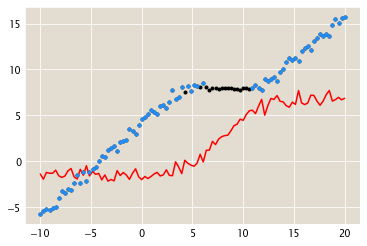

In [505]:
dF = stats[stats['parameter']=='delta_bohr']
_fc_mu = stats[stats['parameter']=='fc_mu']['median'].values
bohr = stats[stats['parameter']=='bohr']['median'].values
fc_sigma = stats[stats['parameter']=='fc_sigma']['median'].values
ddF =  stats[stats['parameter']=='delta_bohr_corrected']
fc_ref = (1 + np.exp(-true_bohr))**-1

# Plot the ground truth. 
ref1 = np.log(fc_sigma**-1 - 1)
# plt.plot(true_bohr, true_bohr - true_bohr + offset, color='dodgerblue')
idx = _fc_mu < fc_sigma
idx2 = (1 - _fc_mu) < fc_sigma

plt.plot(true_bohr, dF['median'], '.', color='k')
# plt.plot(true_bohr, true_bohr - (ref1 +1), 'r-')
# plt.plot(true_bohr, true_bohr - ref1 -1, 'r-')
plt.plot(true_bohr, bohr+ ref1, 'r-')

# plt.plot(true_bohr, dF['median'] - (true_bohr + ref1 +1), 'r-')
# plt.plot(true_bohr, true_bohr)
plt.plot(true_bohr[idx], dF['median'].values[idx], '.', color='dodgerblue')
plt.plot(true_bohr[idx2],dF['median'].values[idx2], '.', color='dodgerblue')


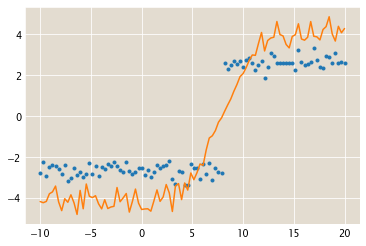

In [537]:
plt.plot(true_bohr ,np.sign(bohr) * np.log(fc_sigma**-1 -1), '.')
plt.plot(true_bohr, bohr)


In [521]:
(-np.log(fc_sigma**-1 - 1))/ -np.log((fc_mu)**-1 -1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ 0.27933475,  0.23513175,  0.31456296,  0.27409438,  0.27305535,
        0.28909594,  0.3192858 ,  0.36286043,  0.32032858,  0.43571101,
        0.4385744 ,  0.38004484,  0.45118077,  0.45426249,  0.52325666,
        0.51925602,  0.45151524,  0.59071192,  0.54317727,  0.69841586,
        0.63433069,  0.71494764,  0.70684706,  0.81129581,  0.83463193,
        1.01926467,  1.2408583 ,  1.52342895,  1.50267017,  2.24389753,
        3.14794542,  4.52257141,  8.43609363,         inf, -9.50931647,
       -4.37463609, -3.28167896, -2.27045217, -1.58095921, -1.41361472,
       -1.16236407, -0.99606786, -0.81112053, -1.02127376, -1.00660018,
       -0.73647878, -0.69435121, -0.79637788, -0.74783063, -0.4860943 ,
       -0.49861138, -0.46846437, -0.53978972, -0.38569893, -0.44942591,
       -0.34392012, -0.44958584, -0.34766976, -0.35956572, -0.3521902 ,
       -0.31377387, -0.2715373 , -0.28316481, -0.29425538, -0.26634036,
       -0.27505364, -0.23942138, -0.2660177 , -0.263326  , -0.23

In [491]:
plt.plot(true_bohr, bohr, '.)
plt.hlines(ref2 - ref1/ref2, -10, 20)
# # # plt.hlines(ref1 + ref2/ref1, -10, 20)
# # plt.vlines(ref2 - ref1/ref2, -10, 20)
# plt.vlines(ref1 + ref2/ref1, -10, 20)
plt.plot(true_bohr, (true_bohr - offset))

SyntaxError: EOL while scanning string literal (<ipython-input-491-ac9cfe050f07>, line 1)

In [346]:
ref1/2

-1.0986122886681098

In [295]:
fc_sigma.mean() - fc_sigma.mean()**2

0.09297393911003839

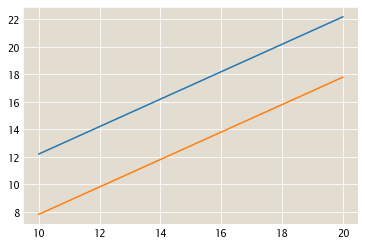

In [288]:
x = np.log(sigma**-1 -1) + true_bohr
x2 = np.log((1 - sigma)**-1 -1) + true_bohr
plt.plot(true_bohr, x)
plt.plot(true_bohr, x2)

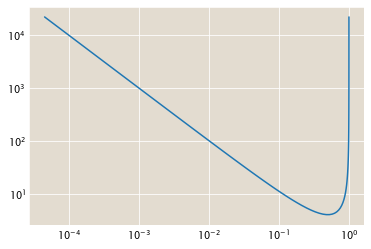

In [65]:
plt.loglog(fc_mu, (fc_mu - fc_mu**2)**-1)

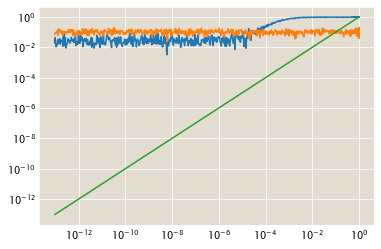

In [260]:
plt.loglog(fc_mu, _fc_mu)
plt.plot(fc_mu, fc_sigma)
plt.plot(fc_mu, fc_mu)
# plt.hlines(sigma, 1E-12, 1E0)

-0.09

In [250]:
np.abs(_fc_mu - fc_sigma)

array([0.04928797, 0.04411021, 0.07962878, 0.08762094, 0.09715158,
       0.08523172, 0.02838548, 0.12749424, 0.08777309, 0.07957115,
       0.11697525, 0.09013476, 0.08540109, 0.05729206, 0.09203702,
       0.0923534 , 0.04856261, 0.04759541, 0.08994987, 0.01468744,
       0.08501951, 0.05803038, 0.06877387, 0.09249787, 0.08478476,
       0.07486438, 0.07432934, 0.11729504, 0.06569598, 0.11776875,
       0.07374174, 0.10970774, 0.0706902 , 0.10085004, 0.1193723 ,
       0.08316593, 0.03689492, 0.10072891, 0.08370483, 0.02797503,
       0.03441166, 0.01164698, 0.0727085 , 0.06944102, 0.09599452,
       0.05376599, 0.05617593, 0.03018146, 0.10685399, 0.04769923,
       0.08681887, 0.01047727, 0.0701217 , 0.02349686, 0.0483616 ,
       0.14062237, 0.07206808, 0.08685926, 0.12033728, 0.04319941,
       0.06926706, 0.06748418, 0.12208849, 0.08831324, 0.02923466,
       0.09579887, 0.09126123, 0.08144593, 0.04349462, 0.10336831,
       0.11662567, 0.08956732, 0.06065173, 0.0771298 , 0.12664

array([-1.30722319, -1.01851675, -1.51772307, -1.31606406, -0.66459054,
       -1.19703455, -1.23001946, -1.50842128, -1.14463107, -1.42366682,
       -1.46714078, -1.3557851 , -1.04889812, -1.25556772, -1.32305636,
       -1.18270792, -1.107145  , -0.79596234, -0.62439258, -0.4076475 ,
        0.14290516,  0.92729159,  0.93477531,  1.35845041,  2.39176496,
        2.58476641,  4.40172244,  4.36044577,  6.45810134,  5.3119916 ,
        7.15016773,  8.74249144,  8.2316376 ,  5.4790476 ,  7.1444103 ,
        4.72139435,  7.47684321,  7.27713217,  6.26366722,  5.3755183 ,
        6.94119591,  5.64952399,  6.55867463, 10.0286378 , 10.66698723,
        6.98116438,  8.16100032,  7.49679224,  7.40942001,  7.17121919])

In [192]:
_fc_mu - fc_sigma

array([-0.12134435, -0.07919435, -0.14236162, -0.12312058, -0.13040312,
       -0.04243056, -0.02960293, -0.05834502,  0.01923115,  0.10241456,
        0.11691001,  0.20741873,  0.3277209 ,  0.38184822,  0.55698328,
        0.54379593,  0.77723595,  0.74206412,  0.79963172,  0.80842618,
        0.73897873,  0.83255615,  0.87096026,  0.80028738,  0.86863443,
        0.89780061,  0.85248783,  0.86613255,  0.81023187,  0.84405923,
        0.83041751,  0.81916711,  0.85454796,  0.79436935,  0.89423527,
        0.803098  ,  0.84177256,  0.8651817 ,  0.81206808,  0.87356719,
        0.7916163 ,  0.81432523,  0.80741297,  0.85332355,  0.81928728,
        0.82588545,  0.84481551,  0.8645048 ,  0.87052537,  0.86450507])

In [131]:
_fc_mu + np.abs((1 - _fc_mu) - fc_sigma)

array([0.90471785, 0.91579848, 0.82752597, 0.89483859, 0.86514997,
       0.79372506, 0.76583742, 0.8163302 , 0.86947962, 0.84537678,
       0.89508668, 0.89066338, 0.89617229, 0.90055223, 0.89242666,
       0.88789084, 0.83332325, 0.86896937, 0.84676082, 0.86710647,
       0.80908479, 0.87143662, 0.89452777, 0.82602361, 0.86772839,
       0.91235155, 0.84471383, 0.88862158, 0.86519347, 0.877274  ,
       0.88238921, 0.98506582, 0.9644828 , 0.979484  , 1.01958034,
       1.06797932, 1.06582875, 1.00408277, 1.04672308, 0.92795623,
       0.95239774, 1.1054585 , 1.0613663 , 1.06164564, 1.08412194,
       1.0648876 , 0.99260019, 1.01479436, 1.15829737, 1.08532434])

In [132]:
1 / (sigma * (1 - sigma))

11.111111111111109

(0.98, 1.0)

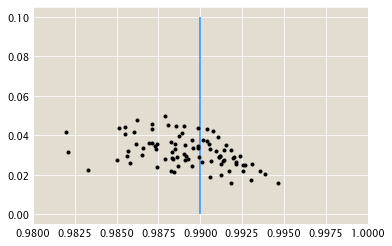

In [551]:
plt.plot(fc_mu, fc_sigma, 'k.')
plt.vlines(1 - sigma, 0, 0.1, color='dodgerblue')
plt.xlim([0.98, 1.0])

In [500]:
~extrema_idx


0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
1970    False
1971    False
1972    False
1973    False
1974    False
1975    False
1976    False
1977    False
1978    False
1979    False
1980    False
1981    False
1982    False
1983    False
1984    False
1985    False
1986    False
1987    False
1988    False
1989    False
1990    False
1991    False
1992    False
1993    False
1994    False
1995    False
1996    False
1997    False
1998    False
1999    False
Length: 2000, dtype: bool

In [430]:
b

array([2.08056874, 1.06640977, 1.23117373, 2.18327734, 1.93821859,
       0.98906727, 1.76162554, 1.7902219 , 1.48740396, 1.73360653,
       2.77035791, 1.3576589 , 1.814929  , 2.30817031, 1.44495306,
       1.46128368, 1.59443775, 2.25207989, 1.87148585, 1.30095299,
       1.94584322, 1.97388415, 1.41481912, 2.01015472, 1.61704168,
       2.06841903, 1.4827174 , 2.43780698, 2.0621103 , 1.27117087,
       1.74986848, 1.42740727, 1.46712267, 2.03528486, 2.54805671,
       1.83266663, 1.78291574, 2.62122681, 1.40247521, 1.16875781,
       1.84903373, 1.79822632, 1.26532321, 2.10771347, 1.59372091,
       1.3020034 , 2.19739   , 2.100521  , 1.84144459, 1.89871974])